In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from utils import *
import scipy.optimize as opt
from Common_functions import *
from tqdm import tqdm
from matplotlib.colors import ListedColormap
from sklearn.preprocessing import StandardScaler, MinMaxScaler

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [3]:
path = '/Users/somayeh/Library/Mobile Documents/com~apple~CloudDocs/Research/Microlensing/Microlensing_Harvard/'

In [4]:
data, labels, IDs = select_points_roman(path,
                                        n_days = 5, 
                                        thresh_mag = 1.03,
                                        cadence = 15/(60*24))

9000it [00:00, 72068.04it/s]


In [5]:
classes = ['Single Lens', 'Stellar Binary Lens', 'Planetary System Lens']
class_ = 1
ind_selected = 13
ind = np.where(labels==class_)[0][ind_selected]

cadence = 15/(60*24)
mjd_t = np.arange(len(data[0])) * cadence

Text(0.5, 1.0, 'An example of a Stellar Binary Lens event')

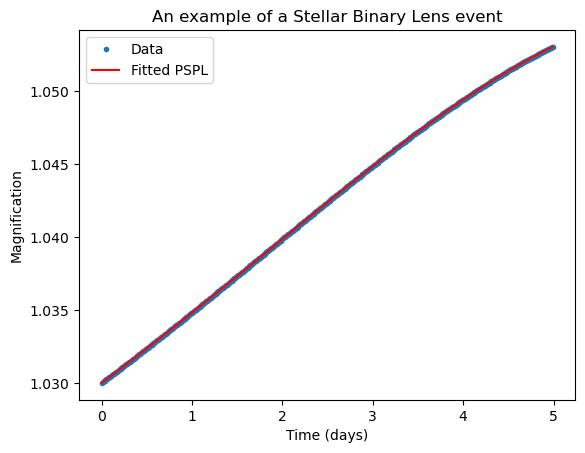

In [6]:
plt.plot(mjd_t, data[ind], '.', label = 'Data')


cheby_all = fit_Cheby(mjd_t, data[ind])
plt.plot(mjd_t, cheby_all['y_fitted'], 'r-', label = 'Fitted PSPL')

plt.legend()
plt.xlabel('Time (days)')
plt.ylabel('Magnification')
plt.title('An example of a %s event'%classes[class_])

In [7]:
all_params = {}
for d, dat in tqdm(enumerate(data)):
    cheby_all = fit_Cheby(mjd_t, dat)
    all_params[d] = cheby_all

8754it [01:04, 136.01it/s]


In [8]:
# for i, key in enumerate(list(all_params.keys())[:10]):
#     plt.figure()
#     plt.plot(mjd_t, data[i], '.', label = 'Data')


#     # cheby_all = fit_Cheby(mjd_t, data[ind])
#     plt.plot(mjd_t, all_params[key]['y_fitted'], 'r-', label = 'Fitted PSPL')

#     plt.legend()
#     plt.xlabel('Time (days)')
#     plt.ylabel('Magnification')
#     plt.title('An example of a %s event'%classes[class_])


In [10]:
labels

array([0., 1., 2., ..., 0., 1., 2.])

/var/folders/6f/k2kn3hn52ws4kc_w0_zqfpy40000gp/T/ipykernel_2449/3518564350.py:23: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm)


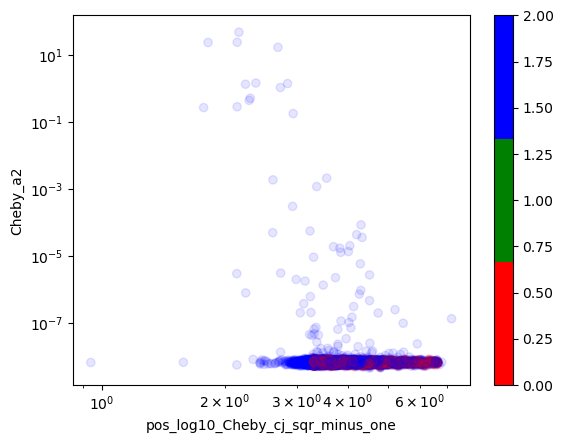

In [14]:
col1 = 'pos_log10_Cheby_cj_sqr_minus_one'
col2 = 'Cheby_a2'
col3 = 'Cheby_a4'
col4 = 'Cheby_a6'
col5 = 'Cheby_a8'
col6 = 'Cheby_a10'
col7 = 'delta_A_chebyshev_sqr'

x1 = get_column_from_dict(all_params, col1)
x2 = get_column_from_dict(all_params, col2)
x3 = get_column_from_dict(all_params, col3)
x4 = get_column_from_dict(all_params, col4)
x5 = get_column_from_dict(all_params, col5)
x6 = get_column_from_dict(all_params, col6)
x7 = get_column_from_dict(all_params, col7)

colormap = ListedColormap(['red', 'green', 'blue'])
sm = plt.cm.ScalarMappable(cmap=colormap)
sm.set_clim(vmin=np.min(labels), 
            vmax=np.max(labels))
colors = colormap(labels)
plt.scatter(x1, x7, c=colors, alpha=0.1)
plt.colorbar(sm)
plt.ylabel(col2)
plt.xlabel(col1)
plt.yscale('log')
plt.xscale('log')



In [20]:
x1

array([4.73400226, 3.82447439, 3.28491023, ..., 3.40147634, 3.8998924 ,
       4.49497297])

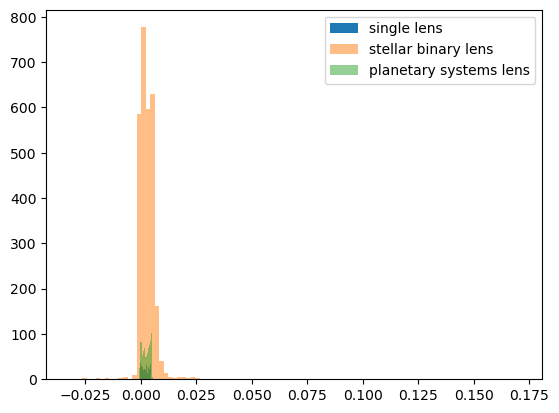

In [29]:
select_feat = x2
# bins = np.linspace(np.min(select_feat), 
#                    np.min(select_feat), 
#                    100)
plt.hist(select_feat[labels==0], bins = 100, label='single lens')
plt.hist(select_feat[labels==1], bins = 100, alpha=0.5, label='stellar binary lens')
plt.hist(select_feat[labels==2], bins = 100, alpha=0.5, label='planetary systems lens')

# plt.yscale('log')
plt.legend()
# plt.xlim(-0.025,0.025)

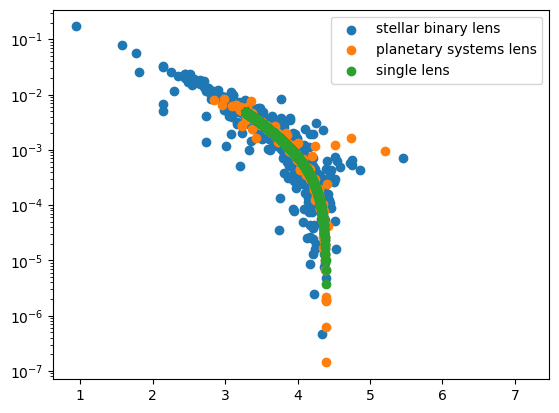

In [57]:
plt.scatter(x1[labels==1], x2[labels==1], label='stellar binary lens')
plt.scatter(x1[labels==2], x2[labels==2], label='planetary systems lens')
plt.scatter(x1[labels==0], x2[labels==0], label='single lens')
# plt.ylim(0.01,1)
plt.yscale('log')
plt.legend()

In [31]:
thre_min = np.min(select_feat[labels==0])
thre_max = np.max(select_feat[labels==0])

print(np.sum(select_feat[labels==1]<thre_min)/len(select_feat)*100)
print(np.sum(select_feat[labels==2]<thre_min)/len(select_feat)*100)

print(np.sum(select_feat[labels==1]>thre_max)/len(select_feat)*100)
print(np.sum(select_feat[labels==2]>thre_max)/len(select_feat)*100)

2.147589673292209
0.4912040210189627
7.402330363262509
0.8339045007996345


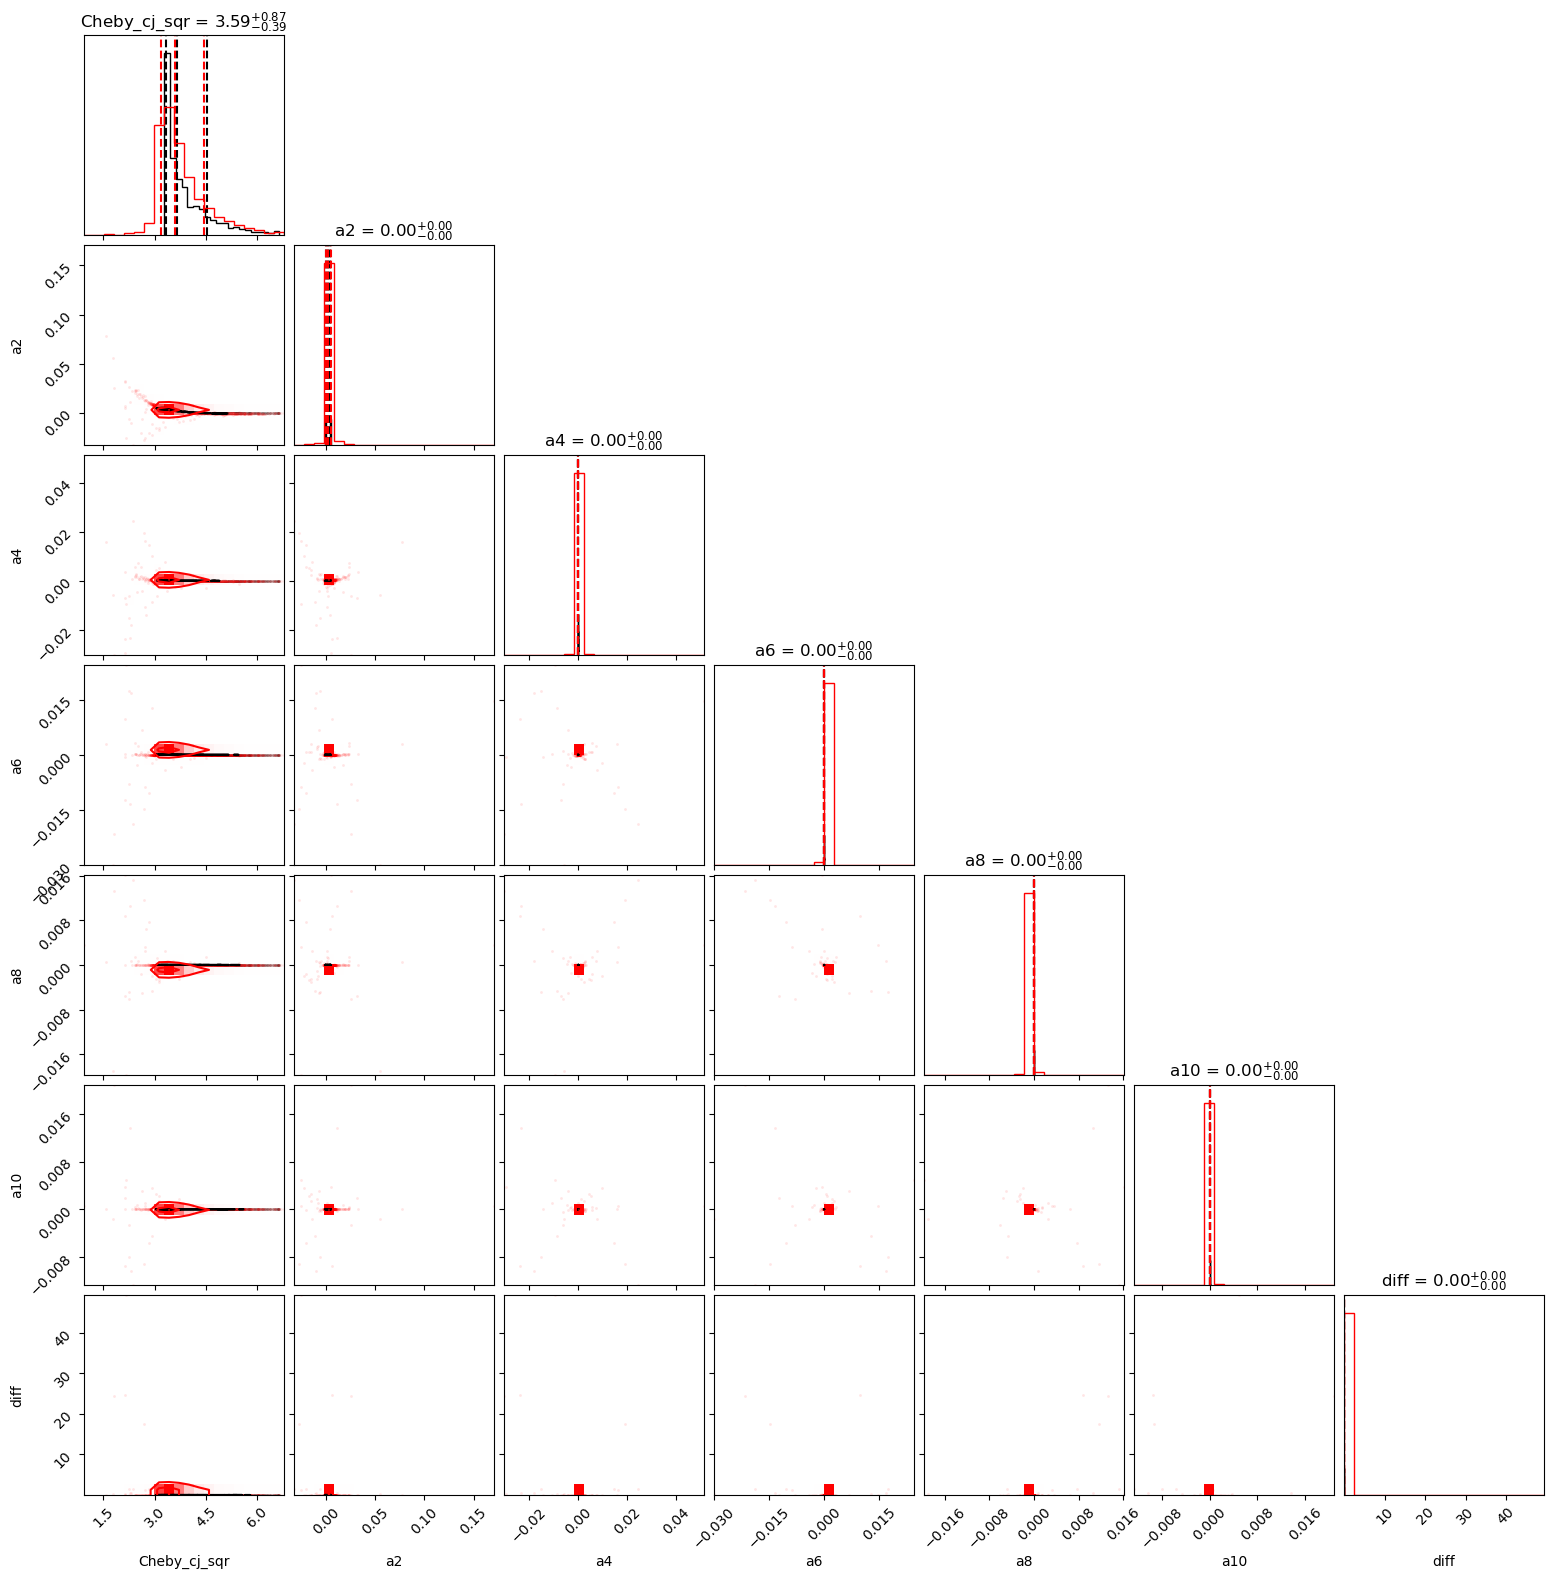

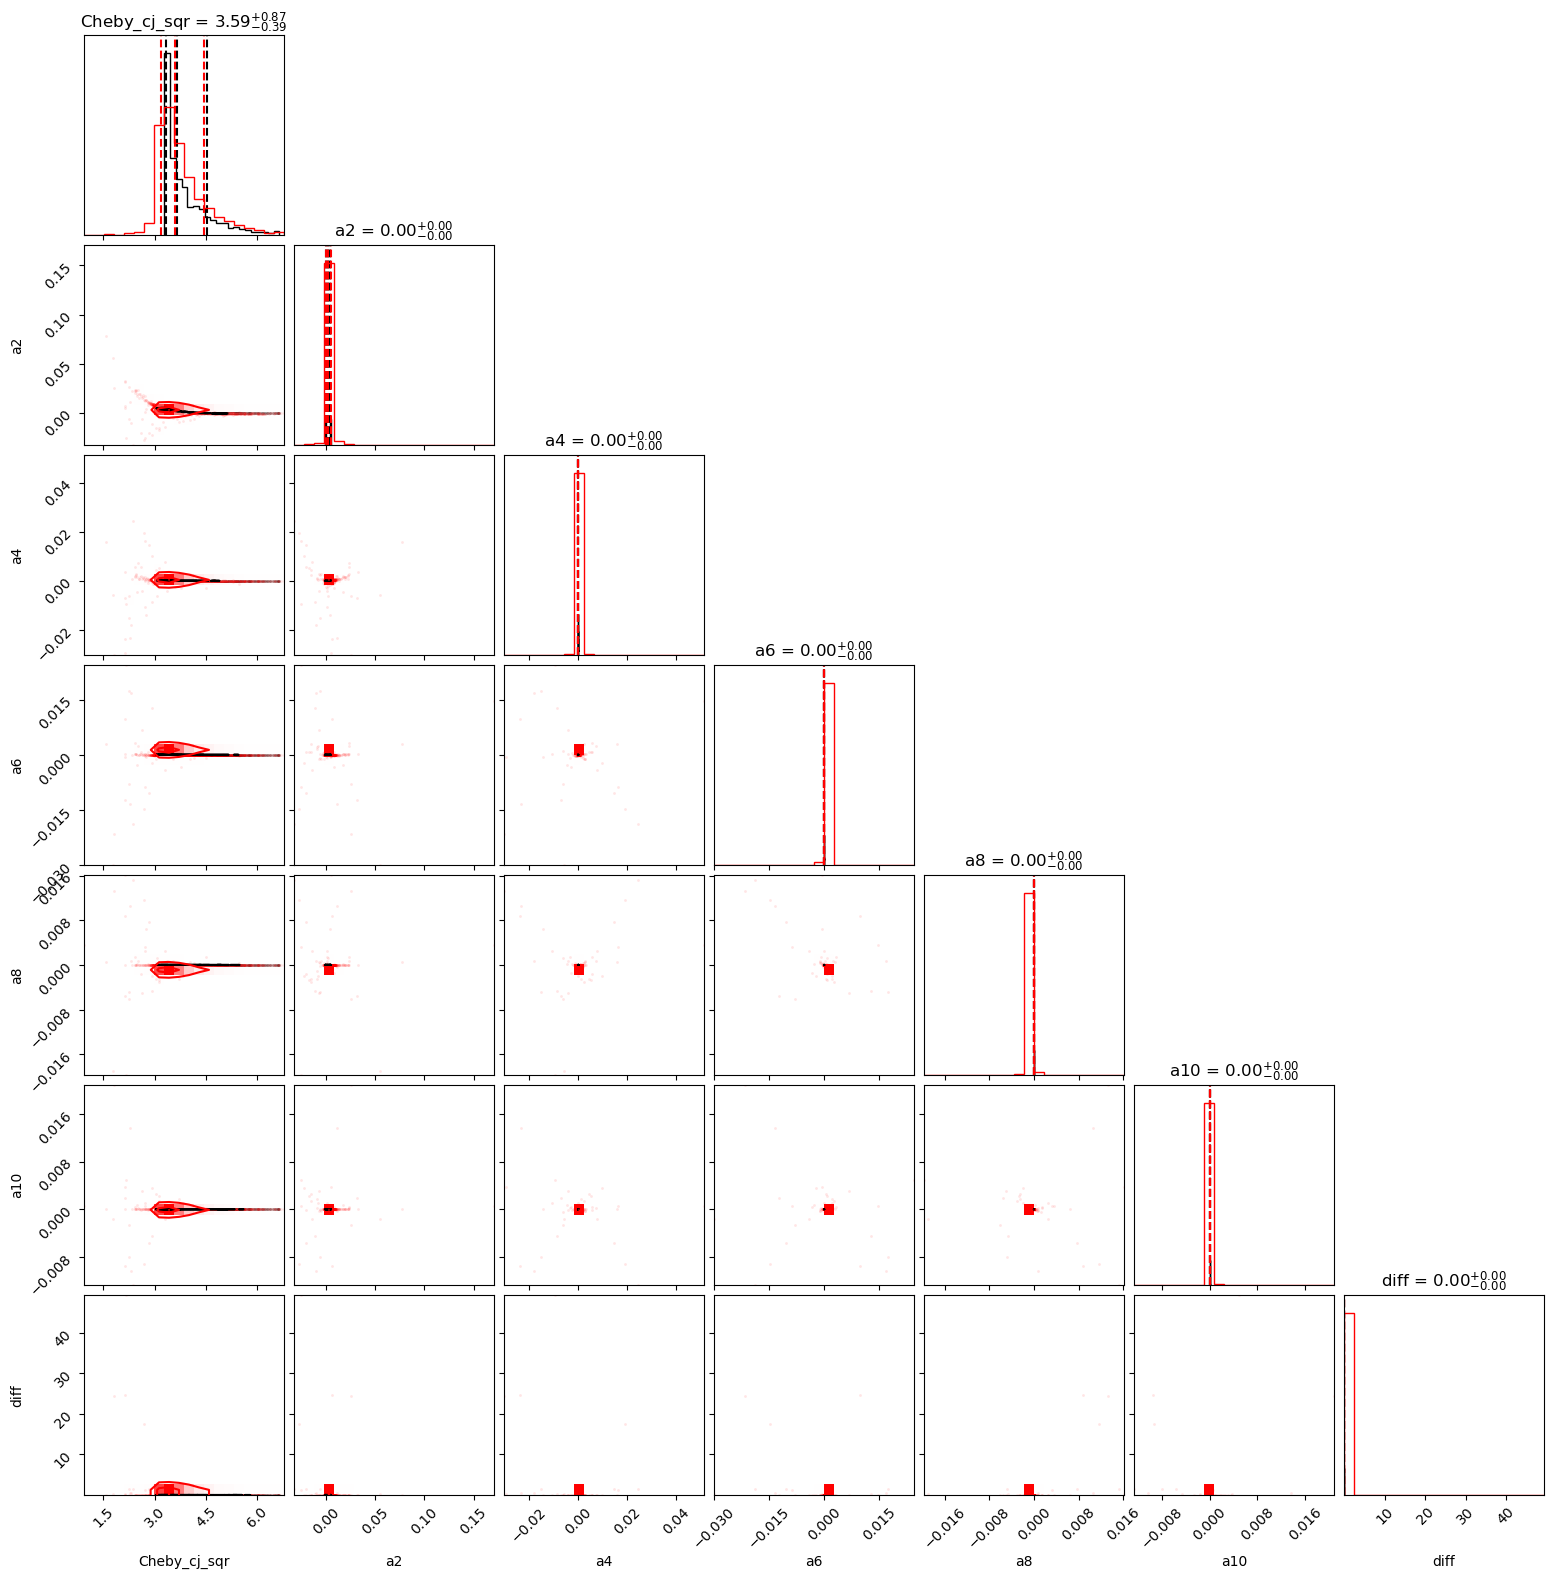

In [80]:
import corner
errors = np.stack((x1, x2, x3, x4, x5, x6, x7), axis=1)
labels_ = ['Cheby_cj_sqr','a2','a4', 'a6', 'a8', 'a10', 'diff']
scaler = MinMaxScaler()
plot_data = scaler.fit_transform(errors)
figure = corner.corner(errors[labels==0], 
                       labels=labels_,
                       quantiles=(0.16,0.5,  0.84),
                      show_titles=True,
                       color='black',
                        title_kwargs={"fontsize": 12})
corner.corner(errors[labels==1], 
                       labels=labels_,
                       quantiles=(0.16,0.5,  0.84),
                      show_titles=True,
                       color='red',
                        fig=figure,
                        title_kwargs={"fontsize": 12})